In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import math
import random
import seaborn as sns
 
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

In [2]:
data = yf.download('ORCL', start="2022-04-29", end="2023-04-29") 
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-04-29,75.339996,75.870003,73.150002,73.400002,72.125854,7946900
2022-05-02,73.930000,74.599998,72.529999,74.000000,72.715439,7379900
2022-05-03,73.849998,74.209999,72.809998,73.290001,72.017761,5211500
2022-05-04,73.379997,75.349998,72.790001,75.209999,73.904434,6759900
2022-05-05,74.000000,74.720001,71.989998,72.800003,71.536285,7197200
...,...,...,...,...,...,...
2023-04-24,95.339996,96.080002,94.970001,95.440002,95.440002,4901700
2023-04-25,95.139999,95.699997,94.019997,94.059998,94.059998,5768800
2023-04-26,93.750000,94.809998,93.339996,93.709999,93.709999,6395500


In [3]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

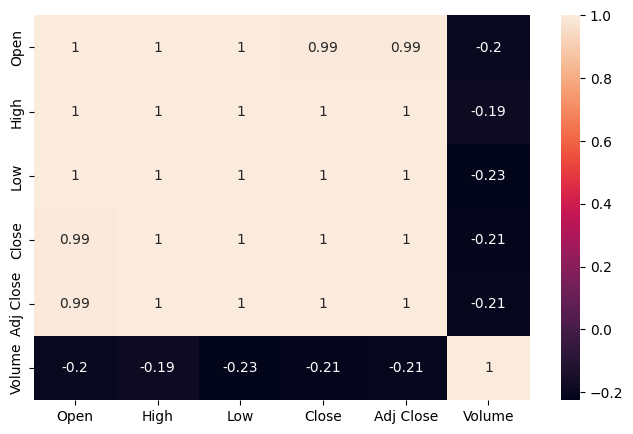

In [4]:
corrMatrix = data.corr()
plt.figure(figsize = (8, 5))
sns.heatmap(corrMatrix, annot=True)
plt.show()

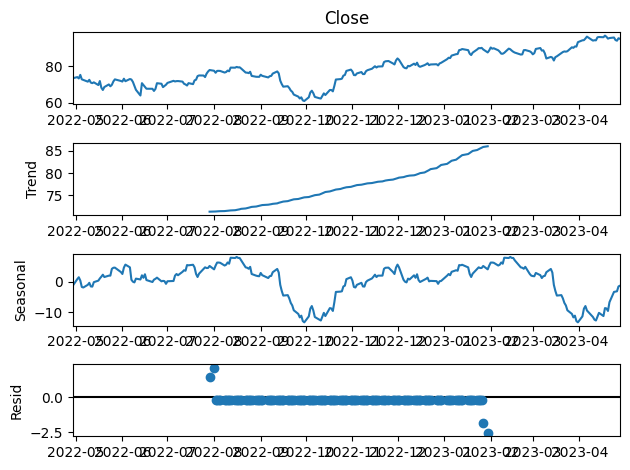

In [5]:
sd = seasonal_decompose(data['Close'], period = 125 ) 
fig = sd.plot()
plt.rcParams['figure.figsize'] = [8.0, 5.0]

In [6]:
df = pd.DataFrame()
df['Date'] = data.index
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format = True)
df['Close'] = data.iloc[: , 3].to_numpy()

data1 = df['Close'].copy()
df

,Date,Close
0,2022-04-29,73.400002
1,2022-05-02,74.000000
2,2022-05-03,73.290001
3,2022-05-04,75.209999
4,2022-05-05,72.800003
...,...,...
246,2023-04-24,95.440002
247,2023-04-25,94.059998
248,2023-04-26,93.709999
249,2023-04-27,95.040001


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    251 non-null    datetime64[ns]
 1   Close   251 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.0 KB


In [8]:
d1 = df.filter(['Close'])
d1 = d1.values
scaler = MinMaxScaler()
d1 = scaler.fit_transform(d1)

d2 = d1[ : len(d1) - 50, 0] 
d2.shape

(201,)

In [9]:
x_train = []
y_train = []
for i in range(25, len(d2)) :
      x_train.append(d2[i - 25 : i] )
      y_train.append(d2[i])

x_train = np.array(x_train)
y_train = np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1) )

In [10]:
# LSTM
model = Sequential()

model.add(LSTM(16, activation = 'relu', input_shape=(x_train.shape[1], 1), return_sequences = True) )

model.add(Dropout(0.1))

model.add(LSTM(8, activation = 'relu', return_sequences = False ) )

model.add(Dropout(0.1))

model.add(Dense(1000, activation = 'relu') )

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25, 16)            1152      
                                                                 
 dropout (Dropout)           (None, 25, 16)            0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 800       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 1000)              9000      
                                                                 
 dense_1 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 11,953
Trainable params: 11,953
Non-traina

In [11]:
d3 = d1[len(d1) - 50 : , 0]
d3.shape

(50,)

In [12]:
x_test = []
y_test = []
for i in range(25, len(d3)) :
  x_test.append(d3[i - 25 : i] )
      
y_test = df.iloc[len(df) - 25 : , 1]

x_test = np.array(x_test)
y_test = np.array(y_test)

print(x_test.shape)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1) )

(25, 25)


In [13]:
model.fit(x_train, y_train, epochs = 25)  

Epoch 1/25
6/6 [==============================] - 3s 14ms/step - loss: 0.1897 - accuracy: 0.0057
Epoch 2/25
6/6 [==============================] - 0s 14ms/step - loss: 0.0909 - accuracy: 0.0057
Epoch 3/25
6/6 [==============================] - 0s 15ms/step - loss: 0.0388 - accuracy: 0.0057
Epoch 4/25
6/6 [==============================] - 0s 14ms/step - loss: 0.0474 - accuracy: 0.0000e+00
Epoch 5/25
6/6 [==============================] - 0s 14ms/step - loss: 0.0344 - accuracy: 0.0057
Epoch 6/25
6/6 [==============================] - 0s 16ms/step - loss: 0.0312 - accuracy: 0.0057
Epoch 7/25
6/6 [==============================] - 0s 13ms/step - loss: 0.0313 - accuracy: 0.0057
Epoch 8/25
6/6 [==============================] - 0s 14ms/step - loss: 0.0256 - accuracy: 0.0057
Epoch 9/25
6/6 [==============================] - 0s 15ms/step - loss: 0.0238 - accuracy: 0.0057
Epoch 10/25
6/6 [==============================] - 0s 14ms/step - loss: 0.0205 - accuracy: 0.0057
Epoch 11/25
6/6 [========

In [14]:
y_train.shape

(176,)

In [15]:
pred = model.predict(x_test) 
pred.shape

1/1 [==============================] - 0s 468ms/step


(25, 1)

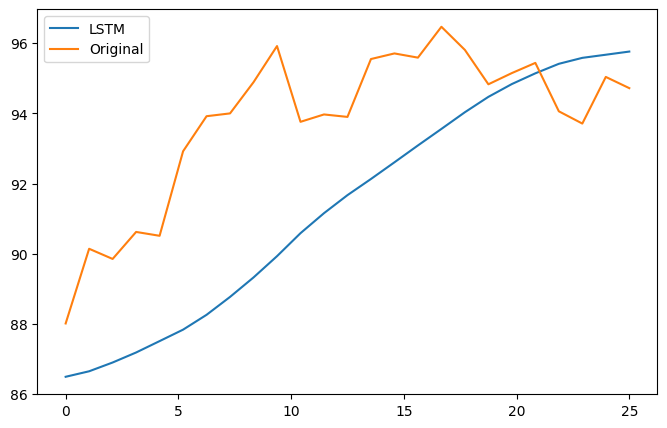

In [16]:
pred = scaler.inverse_transform(pred)

tp = np.linspace(0,25,25)
tp1 = np.linspace(0,25,25)

plt.plot(tp, pred)
plt.plot(tp1, y_test)
plt.legend(['LSTM', 'Original'])
plt.show()

In [17]:
print(math.sqrt(mean_squared_error(y_test, pred)) )

3.259748573778605


/usr/local/lib/python3.10/dist-packages/statsmodels/base/optimizer.py:17: FutureWarning:

Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: X. After release 0.14, this will raise.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  222
Model:               SARIMAX(3, 1, 2)   Log Likelihood                -374.424
Date:                Sun, 30 Apr 2023   AIC                            760.848
Time:                        16:02:57   BIC                            781.237
Sample:                             0   HQIC                           769.081
                                - 222                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4557      0.066     22.007      0.000       1.326       1.585
ar.L2         -1.1489      0.084    -13.687      0.000      -1.313      -0.984
ar.L3          0.1255      0.065      1.936      0.0

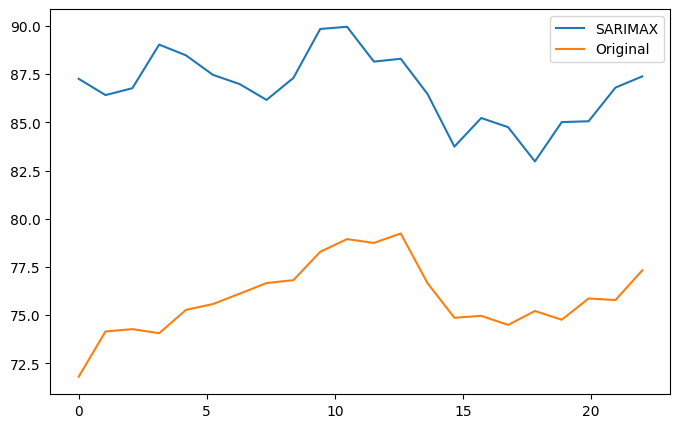

In [18]:
# SARIMAX
data3 = df['Close'] 
    
# Split data into train and test set (90% - train, 10% - test)
train3_data, test3_data = data3[3 : int(len(data3) * 0.9)], data3[int(len(data3) * 0.9) : ] 

# test_values = len(data3) * 0.01 + 1.0 
x_train = list(range(0, 224))
x_test = list(range(224, int(len(data3))))

exo_data = data['Volume']
exo_data = exo_data[int(len(exo_data) * 0.9):]

stock_name = 'ORCL' 

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_train, y=train3_data, mode='lines+markers', marker=dict(size=4),  name='train', marker_color='#39304A'))
fig.add_trace(go.Scatter(x=x_test, y=test3_data, mode='lines+markers', marker=dict(size=4), name='test', marker_color='#A98D75'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x = 0.5, xanchor = "center"),
                  plot_bgcolor='#FFFFFF',  
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),
                  title_text = f'{stock_name} SARIMAX data', title_x = 0.5, 
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
# fig.show()
    
model = SARIMAX(train3_data, order=(3, 1, 2))

arima_model = model.fit(X = exo_data, disp=-1)

print(arima_model.summary())


preds3 = arima_model.predict(n_periods=22, alpha=0.05)

preds3 = np.vstack(preds3)
preds3 = preds3[-22:]
hist_data = yf.download(stock_name, start="2021-04-01", end="2021-05-04")
hist_data = hist_data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
hist_data = hist_data['Close']
hist_data = np.array(hist_data)
    
rmse = np.sqrt(np.mean(((preds3 - hist_data) ** 2)))
print(f'RMSE SARIMAX: {rmse}')
    
preds_gr = np.reshape(preds3, (22,))
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(0, 21)), y=hist_data, mode='lines+markers', name='historical', marker_color='#39304A'))
fig.add_trace(go.Scatter(x=list(range(0, 21)), y=preds_gr, mode='lines+markers', name='predictions', marker_color='#FFAA00'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',  
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),
                  title_text = f'{stock_name} SARIMAX prediction', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
# fig.show()

tp = np.linspace(0,len(preds_gr),len(preds_gr))
tp1 = np.linspace(0,len(preds_gr),len(preds_gr))

plt.plot(tp, preds_gr)
plt.plot(tp1, hist_data)
plt.legend(['SARIMAX', 'Original'])
plt.show()

[*********************100%***********************]  1 of 1 completed
59.967395476112316
0.0011781350773788332
0.2829808897995235


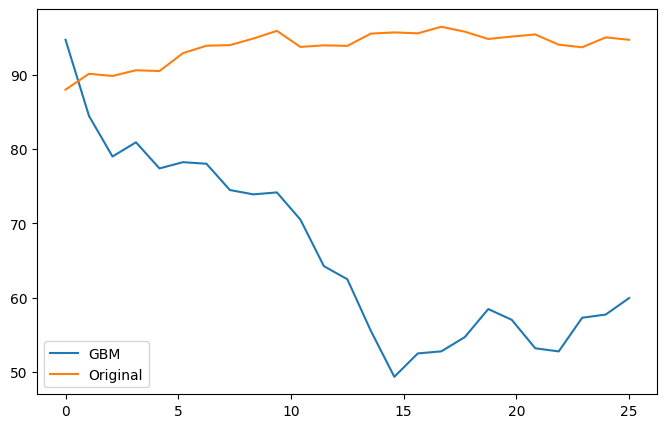

3.259748573778605


In [19]:
# GBM
data_f= yf.download('ORCL', start="2022-04-29", end="2023-04-29") 
df1 = data_f['Close']

n = 25
dt = 1.0/n

df2 = df1.pct_change()

mu = np.mean(df2)
sigma = np.std(df2) * math.sqrt(252)


S0 = df1.iloc[-1]
Wt = np.random.normal(0, 1, n)

S = []
S.append(S0)

for i in range(n-1):
    St = S0 * math.exp( (mu - sigma**2)*dt + sigma*math.sqrt(dt)*Wt[i])
    S.append(St)
    S0 = St

print(St) 
print(mu)
print(sigma)
data1

tp = np.linspace(0,len(S),len(S))
tp1 = np.linspace(0,len(S),len(S))

plt.plot(tp, S)
plt.plot(tp1, y_test)
plt.legend(['GBM', 'Original'])
plt.show()

print(math.sqrt(mean_squared_error(y_test, pred)) )

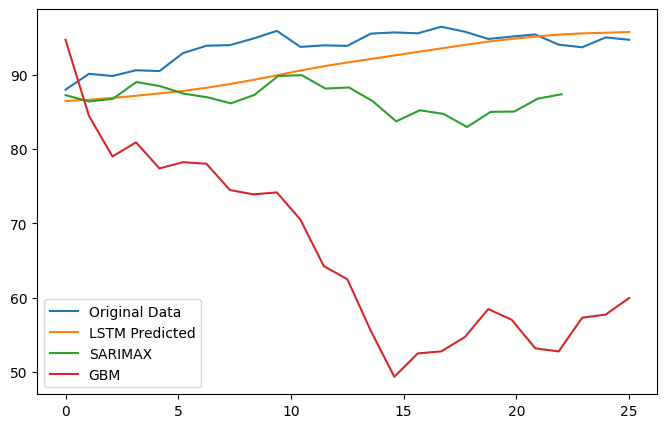

In [20]:
t1 = np.linspace(0,25,25)
t2 = np.linspace(0,22,22)


plt.plot(t1, y_test)
plt.plot(t1, pred)
plt.plot(t2, preds_gr)
plt.plot(t1, S)

plt.legend(['Original Data', 'LSTM Predicted', 'SARIMAX', 'GBM'])
plt.show()

In [21]:
!python -m pip install -U git+https://github.com/coin-or/pulp

import pulp as plp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/coin-or/pulp to /tmp/pip-req-build-20a5_lpy
  Running command git clone --filter=blob:none --quiet https://github.com/coin-or/pulp /tmp/pip-req-build-20a5_lpy
  Resolved https://github.com/coin-or/pulp to commit a7684ac90d93dc3bca382d90841a9ab5f398b50f
  Preparing metadata (setup.py) ... done
  Created wheel for PuLP: filename=PuLP-2.7.0-py3-none-any.whl size=14255604 sha256=29b5c49c3b5b8504a5c5cb59141bc1720c416f93cd113f2653230a3b9e694ec5
  Stored in directory: /tmp/pip-ephem-wheel-cache-em3kl9nf/wheels/eb/a3/b3/31f5ccf83e3c79876202c04033ff3368f7d1e99f59e87e4697
Successfully built PuLP


[*********************100%***********************]  1 of 1 completed
model solve
Model status:  Optimal
Optimal_weights:
MINIMIZE
-86.77084483403436*weight_arima + -90.34816284179688*weight_lstm + -68.65503062697883*weight_mcmc + 71.21550025939942
SUBJECT TO
_C1: weight_arima + weight_lstm + weight_mcmc <= 1

_C2: weight_arima + weight_lstm + weight_mcmc >= 1

VARIABLES
weight_arima <= 0.6 Continuous
weight_lstm <= 0.6 Continuous
weight_mcmc <= 0.6 Continuous



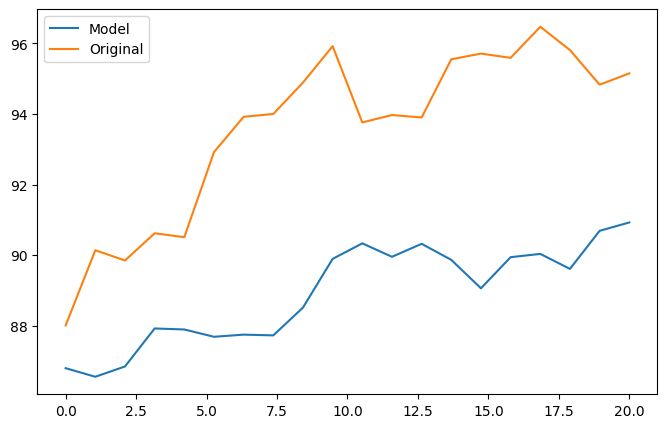

RMSE = 4.207343384790923
LSTM weight: 0.6
GBM weight: 0.0
SARIMAX weight: 0.4


In [22]:
a1 = yf.download('ORCL', start="2022-04-29", end="2023-04-29") 

b1 = a1['Close']
b1 = np.array(b1)

final_pred = []
final_mse = []

wt_lstm = 0.4
wt_gbm = 0.3
wt_sarimax = 0.3


model = plp.LpProblem('Optimal_weights', plp.LpMinimize)

wt_lstm = plp.LpVariable("weight_lstm", lowBound = 0, upBound=0.6)
wt_gbm = plp.LpVariable("weight_mcmc", lowBound = 0, upBound=0.6)
wt_sarimax = plp.LpVariable("weight_arima", lowBound = 0, upBound=0.6)

for i in range(20):
    final_pred.append(pred[i]*wt_lstm + S[i]*wt_gbm + preds_gr[i]*wt_sarimax)
    
for i in range (20):
    final_mse.append(b1[i] - final_pred[i])

final_mse = np.mean(final_mse)
sum_w = wt_lstm + wt_gbm + wt_sarimax 

model += final_mse
model += sum_w <= 1.0
model += sum_w >= 1.0

plp.LpSolverDefault.msg = 1


model.solve()
print('model solve')
status = model.solve()
print("Model status: ", plp.LpStatus[status])
print(model)

wt_lstm_f = wt_lstm.varValue
wt_gbm_f = wt_gbm.varValue
wt_sarimax_f = wt_sarimax.varValue


fpred = []

for i in range(20):
    fpred.append(pred[i]*wt_lstm_f + S[i]*wt_gbm_f + preds_gr[i]*wt_sarimax_f)

fpred = np.vstack(fpred)    



preds_gr = np.reshape(fpred, (20,))
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(0, 21)), y=hist_data, mode='lines+markers',  name='historical', marker_color='#39304A'))
fig.add_trace(go.Scatter(x=list(range(0, 21)), y=preds_gr, mode='lines+markers', name='predictions', marker_color='#FFAA00'))
fig.update_layout(legend_orientation="h",
                legend=dict(x=.5, xanchor="center"),
                plot_bgcolor='#FFFFFF',  
                xaxis=dict(gridcolor = 'lightgrey'),
                yaxis=dict(gridcolor = 'lightgrey'), 
                title_text = f'{stock_name} final prediction', title_x = 0.5,
                xaxis_title="Timestep",
                yaxis_title="Stock price",
                margin=dict(l=0, r=0, t=30, b=0))
# fig.show()
tp = np.linspace(0,len(preds_gr),len(preds_gr))
tp1 = np.linspace(0,len(preds_gr),len(preds_gr))

plt.plot(tp, preds_gr)
plt.plot(tp1, y_test[:len(preds_gr)])
plt.legend(['Model', 'Original'])
plt.show()

# print(math.sqrt(mean_squared_error(y_test, pred)) )


mse1 = []
for i in range (20):
    mse1.append(abs(b1[i] - fpred[i]))
mse1 = np.mean(mse1)
rmse = math.sqrt(mse1)

print(f'RMSE = {rmse}')
print(f'LSTM weight: {wt_lstm_f}')
print(f'GBM weight: {wt_gbm_f}')
print(f'SARIMAX weight: {wt_sarimax_f}')

In [23]:
# American Put Option

z1 = df.iloc[226 : , 1]
z1 = z1.to_numpy()

S0 = z1[0]
ind = 0

for i in range(len(z1)) :
    if z1[i] < S0 :
       S0 = z1[i]
       ind = i

options = yf.Ticker("ORCL").option_chain("2023-05-05")
Kmean = options.puts.strike.mean()/0.9

print("Mean Strike Price for Oracle: ", Kmean) 

Mean Strike Price for Oracle:  95.51282051282051


In [24]:
r = 3.54

Put_Price = math.exp(-r*(ind/252.0))*max(Kmean - S0 , 0)
print("American Put Option Price", Put_Price)

American Put Option Price 7.502818376590042
